# LabelMe Dataset

* Input patterns: $256\times256$ real RGB images of landscapes.
* Labels: Mutually exclusive types of landscape.
    * Classes: *highway, insidecity, tallbuilding, street, forest, coast, mountain, opencountry*
* Ground truth: The original/real image landscape.
* Annotations: re-collected from Amazon Mechanical Turk (AMT).
    * Number of annotators (T) = 59  

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc
np.set_printoptions(precision=4, suppress=True)

In [15]:
#GLOBAL Variables
BATCH_SIZE = 64 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2

In [16]:
folder = "./data/LabelMe/"

### Load Data and preprocess

In [17]:
Xstd_train = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

Xstd_val = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

Xstd_test = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",Xstd_train.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


### Load annotations 

In [5]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1

N,T = y_obs.shape
print("Shape (data,annotators): ",(N,T))
print("Classes: ",np.max(y_obs)+1)

Loading AMT data...
Shape (data,annotators):  (1000, 59)
Classes:  8


### Upper Bound Model -- ideal

In [6]:
#### Delta Convergence criteria
from codeE.learning_models import MLP_Keras, Clonable_Model
from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

In [7]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB, model_UB.input)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained IDeal Model, Epochs to converge = 12


In [8]:
from codeE.evaluation import f1score_model
print("Train accuracy of model =", f1score_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", f1score_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.9910402838396923
Test accuracy of model = 0.9312395723181581


### Generate Matrix representation of both scenarios

> New representation type, masked with -1

In [9]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape, masked with 0 (default) (N,K,T)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape, masked with 0 (default) (N,K,T)=  (1000, 59, 8)
Global representation shape (N,K)=  (1000, 8)


The representation used on the original CrowdLayer code could also be used
> https://github.com/fmpr/CrowdLayer

y_obs_catmasked = set_representation(y_obs, 'onehotmasked')  #masked with -1 and reshaped 
y_obs_catmasked_v2 = set_representation(y_obs, 'onehot', masked=-1)  
y_obs_catmasked_v2 = y_obs_catmasked_v2.transpose([0,2,1])
assert np.all(y_obs_catmasked_v2 ==y_obs_catmasked)

## Rodrigues 18' (Raykar without EM)

In [35]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [19]:
from codeE.methods import ModelInf_BP as Rodrigues18
Ro_model = Rodrigues18()
#Ro_model = Rodrigues18(init_Z="softmv", n_init_Z= 3, init_conf="model",
#                       prior_lamb = 0) #prior on lambda KL restriction on MV
#lambda could be prop to r_obs.sum(axis=-1).mean()

##does not need epochs.. it trains the model entirely at once
args = {'batch_size':BATCH_SIZE, 'optimizer':OPT} 
Ro_model.set_model(model_R, **args)

# if you want you can initialize the auxiliar model to train
#Ro_model.init_model(Xstd_train, y_obs_categorical)
#Ro_model.model_crowdL.summary()

logL_hists, i_r = Ro_model.fit(Xstd_train, y_obs_categorical, runs=10, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing...
Epoch 1/50
1000/1000 [==============================] - 0s 287us/step - loss: 5.0936
Epoch 2/50
1000/1000 [==============================] - 0s 59us/step - loss: 4.6897
Epoch 3/50
1000/1000 [==============================] - 0s 55us/step - loss: 4.3634
Epoch 4/50
1000/1000 [==============================] - 0s 62us/step - loss: 4.1725
Epoch 5/50
1000/1000 [==============================] - 0s 55us/step - loss: 4.0514
Epoch 6/50
1000/1000 [==============================] - 0s 52us/step - loss: 4.0373
Finished training
Initializing...
Epoch 1/50
1000/1000 [==============================] - 0s 249us/step - loss: 5.0517
Epoch 2/50
1000/1000 [==============================] - 0s 49us/step - loss: 4.6264
Epoch 3/50
1000/1000 [==============================] - 0s 55us/step - loss: 4.4604
Epoch 4/50
1000/1000 [==============================] - 0s 51us/step - loss: 4.3333
Epoch 5/50
1000/1000 [==============================] - 0s 46us/step - loss: 4.2302
Epoch 6/50
1000/1000 [==

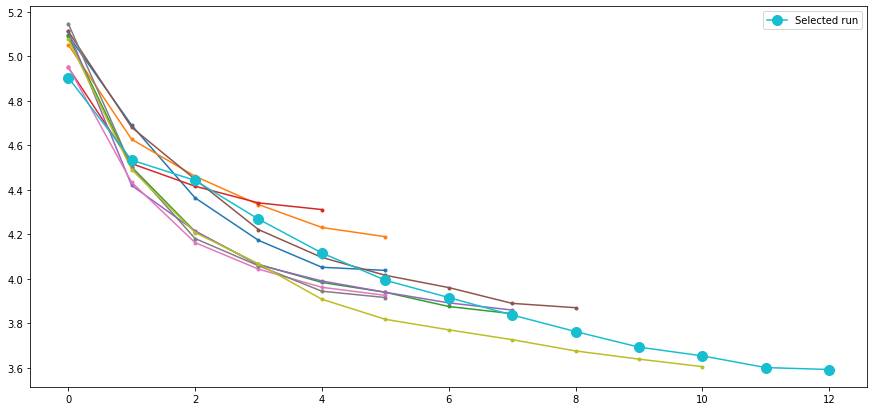

In [20]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [21]:
raykar_fx = Ro_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

Train accuracy of model = 0.854
Test accuracy of model = 0.8434343434343434


## Global Behavior - Label Noise
Based on Noise Channel of Bekker and Goldberg

In [22]:
aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [23]:
from codeE.methods import ModelInf_BP_G as G_Noise
GNoise_model = G_Noise() 
#GNoise_model = G_Noise(init_Z='softmv', n_init_Z=3, init_conf = "model") 

args = {'batch_size':BATCH_SIZE, 'optimizer':OPT}
GNoise_model.set_model(aux_model, **args)

# if you want you can initialize the auxiliar model to train
#GNoise_model.init_model(Xstd_train, r_obs)
loss_hists,i_r = GNoise_model.fit(Xstd_train, r_obs, runs =10, max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing...
Epoch 1/50
1000/1000 [==============================] - 0s 301us/step - loss: 5.9176
Epoch 2/50
1000/1000 [==============================] - 0s 52us/step - loss: 3.8552
Epoch 3/50
1000/1000 [==============================] - 0s 59us/step - loss: 3.2448
Epoch 4/50
1000/1000 [==============================] - 0s 61us/step - loss: 2.7988
Epoch 5/50
1000/1000 [==============================] - 0s 65us/step - loss: 2.4930
Epoch 6/50
1000/1000 [==============================] - 0s 58us/step - loss: 2.2646
Epoch 7/50
1000/1000 [==============================] - 0s 58us/step - loss: 2.2460
Finished training
Initializing...
Epoch 1/50
1000/1000 [==============================] - 0s 240us/step - loss: 5.3868
Epoch 2/50
1000/1000 [==============================] - 0s 47us/step - loss: 3.2878
Epoch 3/50
1000/1000 [==============================] - 0s 54us/step - loss: 2.6320
Epoch 4/50
1000/1000 [==============================] - 0s 49us/step - loss: 2.5248
Epoch 5/50
1000/1000 [==

1000/1000 [==============================] - 0s 51us/step - loss: 1.9304
Epoch 11/50
1000/1000 [==============================] - 0s 48us/step - loss: 1.8555
Epoch 12/50
1000/1000 [==============================] - 0s 49us/step - loss: 1.8119
Epoch 13/50
1000/1000 [==============================] - 0s 48us/step - loss: 1.7948
Finished training
Initializing...
Epoch 1/50
1000/1000 [==============================] - 0s 241us/step - loss: 5.1309
Epoch 2/50
1000/1000 [==============================] - 0s 55us/step - loss: 3.2841
Epoch 3/50
1000/1000 [==============================] - 0s 63us/step - loss: 2.7737
Epoch 4/50
1000/1000 [==============================] - 0s 65us/step - loss: 2.4468
Epoch 5/50
1000/1000 [==============================] - 0s 60us/step - loss: 2.3100
Epoch 6/50
1000/1000 [==============================] - 0s 64us/step - loss: 2.2370
Epoch 7/50
1000/1000 [==============================] - 0s 49us/step - loss: 2.1301
Epoch 8/50
1000/1000 [===========================

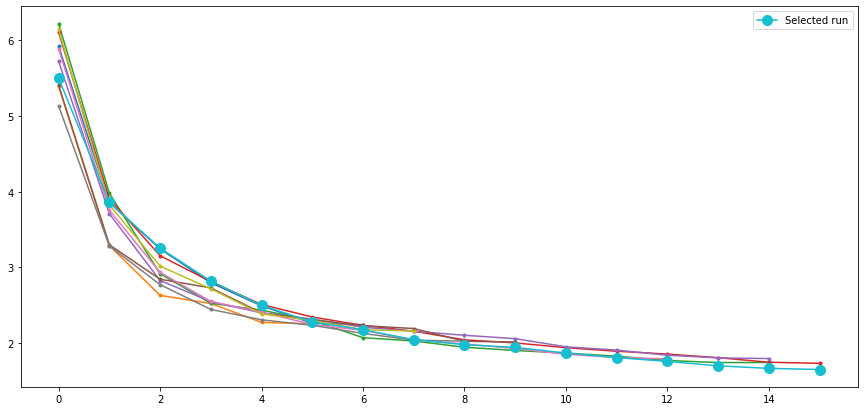

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(loss_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(loss_hists[i_r])),loss_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [25]:
G_fx = GNoise_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(G_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(G_fx, Xstd_test, Z_test))

Train accuracy of model = 0.821
Test accuracy of model = 0.8291245791245792


## Confusion Matrices Visualization

In [26]:
from codeE.utils import generate_confusionM
from codeE.utils import plot_confusion_matrix, compare_conf_ma, compare_set_conf_ma
from codeE.evaluation import Individual_D, D_JS, D_NormF

### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [27]:
from codeE.utils import generate_Individual_conf, generate_Global_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)

confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

Individual matrix shape (T,K,K)=  (59, 8, 8)
Global matrix shape (K,K)=  (8, 8)


> ### Global scenario

#### Global - Label Noise (with predictive model)

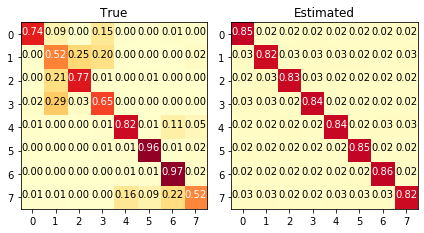

Global D (based on Jensen Shannon) = 0.10079655942008599
Global D (based on normalized Frobenius) = 0.091730497777462


In [28]:
prob_Yz = GNoise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

> What about the confuion matrix init with the model confusion on the pre-init

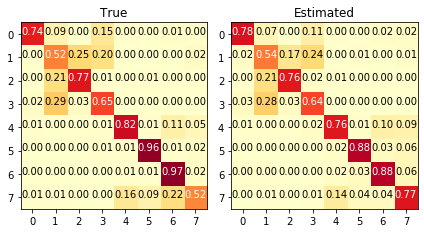

Global D (based on Jensen Shannon) = 0.022047282336996255
Global D (based on normalized Frobenius) = 0.04579969868063927


In [37]:
prob_Yz = GNoise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

> ###  Individual scenario

#### Rodrigues

Plot 5 random matrices from the set


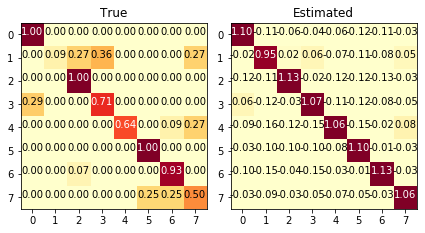

D (based on Jensen Shannon) = 0.13472570524109667
D (based on normalized Frobenius) = 0.1906343251466751


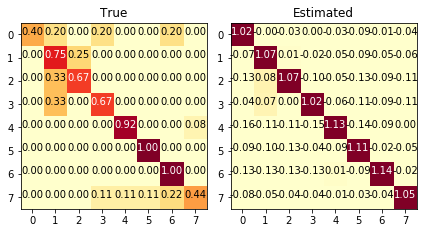

D (based on Jensen Shannon) = 0.1341767796152053
D (based on normalized Frobenius) = 0.1783045381307602


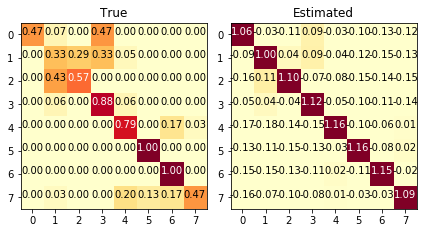

D (based on Jensen Shannon) = 0.17698337965303085
D (based on normalized Frobenius) = 0.21123208105564117


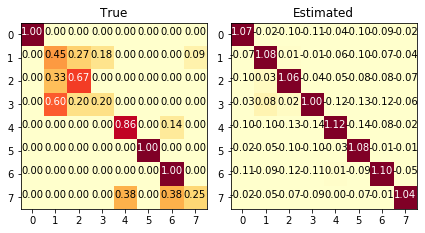

D (based on Jensen Shannon) = 0.18954444427735076
D (based on normalized Frobenius) = 0.21988311409950256


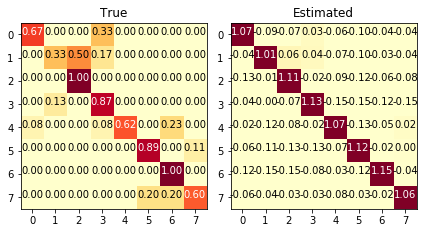

D (based on Jensen Shannon) = 0.12596796169819802
D (based on normalized Frobenius) = 0.18126851320266724


In [29]:
prob_Yzt = Ro_model.get_ann_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

Negatives values on confusion matrix?
> Because the Rodrigues implementation does not consider a probabilistic confusion matrix

Plot 5 random matrices from the set


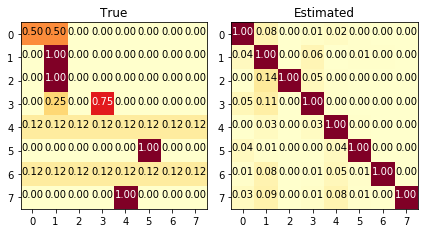

D (based on Jensen Shannon) = 0.37374564556637035
D (based on normalized Frobenius) = 0.30176085233688354


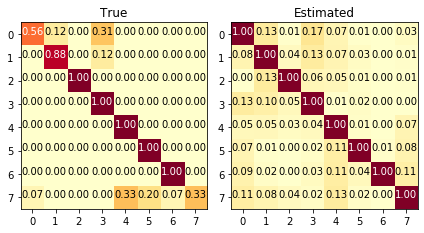

D (based on Jensen Shannon) = 0.13463222192143706
D (based on normalized Frobenius) = 0.11900714784860611


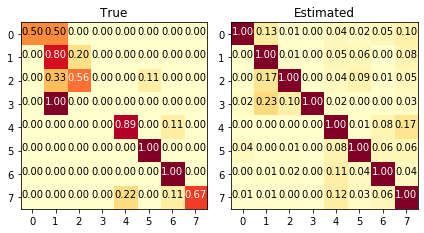

D (based on Jensen Shannon) = 0.1854130125448303
D (based on normalized Frobenius) = 0.19878339767456055


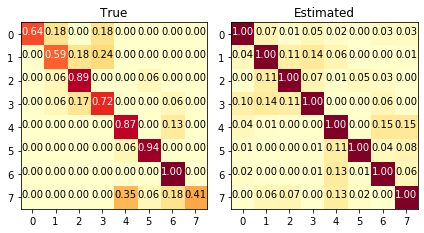

D (based on Jensen Shannon) = 0.09851688638723674
D (based on normalized Frobenius) = 0.12414480000734329


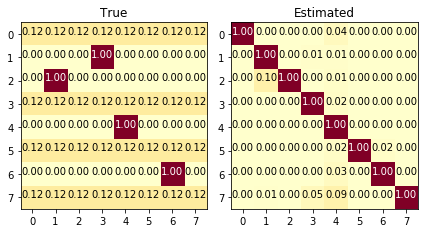

D (based on Jensen Shannon) = 0.5308513241772562
D (based on normalized Frobenius) = 0.3364914357662201


In [30]:
prob_Yzt = Ro_model.get_ann_confusionM(norm="01") 

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [31]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.24862457107634867
Individual D_NormF =  0.20881905242548152


As we can see, as this model does not take into account the learning of a probabilistic matrix, it does not learn the annotators error patterns. 
The explicit models through the strong theory of EM learn this, yet backpropagation-only models are simpler to obtain a good ground truth estimation.

> What about the confusion matrix initialization obtained with the model confusion (based on global label noise methods)?

Plot 5 random matrices from the set


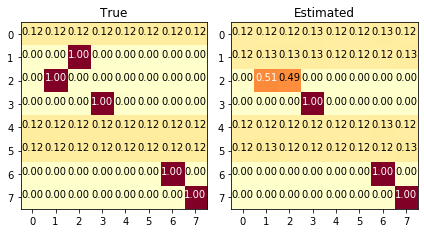

D (based on Jensen Shannon) = 0.12677926835581196
D (based on normalized Frobenius) = 0.14526750147342682


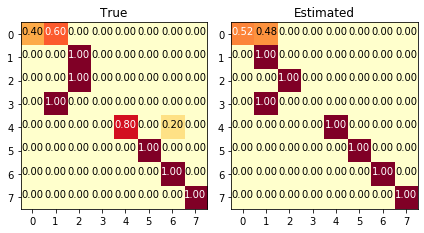

D (based on Jensen Shannon) = 0.13977494388777786
D (based on normalized Frobenius) = 0.18148459494113922


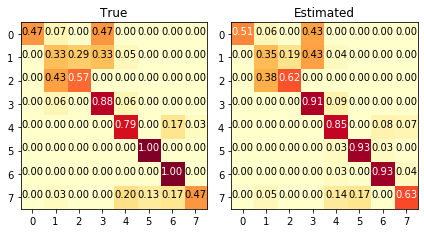

D (based on Jensen Shannon) = 0.029359432426139875
D (based on normalized Frobenius) = 0.043783966451883316


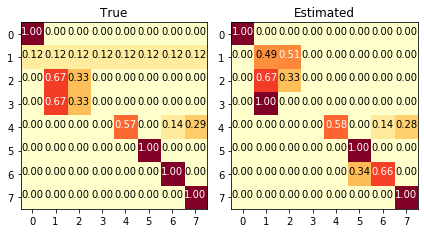

D (based on Jensen Shannon) = 0.11689683351868028
D (based on normalized Frobenius) = 0.11381525546312332


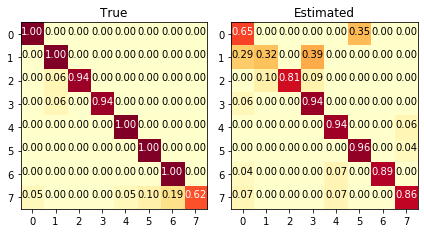

D (based on Jensen Shannon) = 0.13136896935938774
D (based on normalized Frobenius) = 0.13123080134391785


In [42]:
prob_Yzt = Ro_model.get_ann_confusionM(norm="softmax") #--pretty good confusion matrixs

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [43]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.0970010118234137
Individual D_NormF =  0.10304622036322036
